>>> BƯỚC 1: Cấu hình và Thiết lập <<<

>>> BƯỚC 2: Tải và Tiền xử lý Dữ liệu <<<
Bắt đầu đọc dữ liệu từ thư mục: scaled_output_parquet/
  (1/50) Đang xử lý file: part.6.parquet...
  (2/50) Đang xử lý file: part.19.parquet...
  (3/50) Đang xử lý file: part.28.parquet...
  (4/50) Đang xử lý file: part.2.parquet...
  (5/50) Đang xử lý file: part.31.parquet...
  (6/50) Đang xử lý file: part.24.parquet...
  (7/50) Đang xử lý file: part.38.parquet...
  (8/50) Đang xử lý file: part.20.parquet...
  (9/50) Đang xử lý file: part.21.parquet...
  (10/50) Đang xử lý file: part.47.parquet...
  (11/50) Đang xử lý file: part.25.parquet...
  (12/50) Đang xử lý file: part.48.parquet...
  (13/50) Đang xử lý file: part.30.parquet...
  (14/50) Đang xử lý file: part.33.parquet...
  (15/50) Đang xử lý file: part.42.parquet...
  (16/50) Đang xử lý file: part.18.parquet...
  (17/50) Đang xử lý file: part.7.parquet...
  (18/50) Đang xử lý file: part.17.parquet...
  (19/50) Đang xử lý file: part.1.parquet...
  (

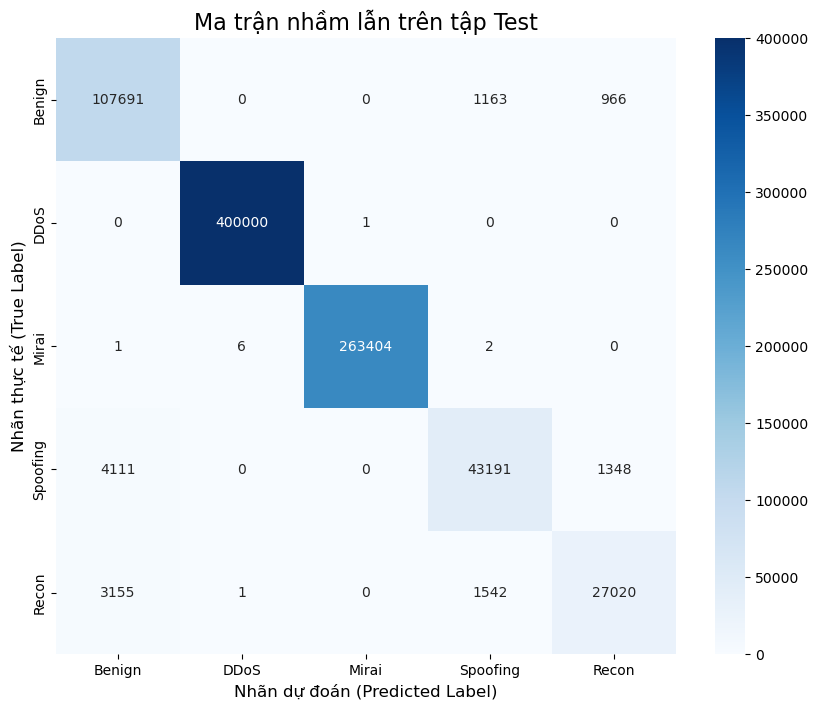


📊 Đang vẽ biểu đồ mức độ quan trọng của Features...


<Figure size 1000x1000 with 0 Axes>

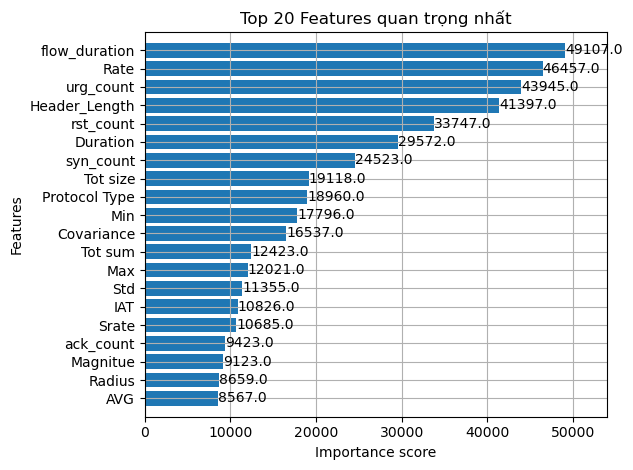


✅ Hoàn tất quá trình huấn luyện và đánh giá.


In [1]:
import pandas as pd
import numpy as np
import os
import glob
import warnings
import gc

# Thư viện cho Machine Learning
from sklearn.model_selection import train_test_split
# LabelEncoder không còn cần thiết
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb

# Thư viện để vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print(">>> BƯỚC 1: Cấu hình và Thiết lập <<<")

# --- CẬP NHẬT ĐƯỜNG DẪN VÀ TÊN NHÃN ---
# Đường dẫn đến thư mục chứa các file parquet đã được scale và có nhãn
DATA_DIR = 'scaled_output_parquet/' 

# Tên các lớp theo đúng thứ tự 0-4 từ biểu đồ bạn cung cấp
CLASS_NAMES = ['Benign', 'DDoS', 'Mirai', 'Spoofing', 'Recon']

# Hàm giảm bộ nhớ (giữ nguyên)
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type.name != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Bộ nhớ giảm từ {start_mem:.2f} MB xuống {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}%)')
    return df

# Hàm tải dữ liệu (giữ nguyên)
def load_data_from_parquet_directory(directory_path):
    print(f"Bắt đầu đọc dữ liệu từ thư mục: {directory_path}")
    all_files = glob.glob(os.path.join(directory_path, '*.parquet'))
    if not all_files:
        print(f"⚠️ Cảnh báo: Không tìm thấy file .parquet nào trong '{directory_path}'.")
        return pd.DataFrame()
    df_chunks = []
    for i, file_path in enumerate(all_files):
        print(f"  ({i+1}/{len(all_files)}) Đang xử lý file: {os.path.basename(file_path)}...")
        chunk_df = pd.read_parquet(file_path)
        chunk_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        chunk_df.fillna(0, inplace=True)
        chunk_df = reduce_mem_usage(chunk_df, verbose=False)
        df_chunks.append(chunk_df)
    print("Ghép các file đã xử lý...")
    full_df = pd.concat(df_chunks, ignore_index=True)
    full_df = reduce_mem_usage(full_df)
    del df_chunks
    gc.collect()
    return full_df

# Hàm vẽ biểu đồ (giữ nguyên)
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=16)
    plt.ylabel('Nhãn thực tế (True Label)', fontsize=12)
    plt.xlabel('Nhãn dự đoán (Predicted Label)', fontsize=12)
    plt.show()

print("\n>>> BƯỚC 2: Tải và Tiền xử lý Dữ liệu <<<")

full_df = load_data_from_parquet_directory(DATA_DIR)

if not full_df.empty:
    print("\nTiền xử lý chung...")
    # Biến đổi log1p (nếu cần)
    problematic_features = ["Rate", "Std length", "Variance length"]
    for col in problematic_features:
        if col in full_df.columns:
            full_df[col] = np.log1p(full_df[col].astype(np.float32))

    # BỎ BƯỚC MÃ HÓA NHÃN VÌ DỮ LIỆU ĐÃ ĐƯỢC MÃ HÓA SẴN
    print("Dữ liệu đã được mã hóa nhãn sẵn, bỏ qua LabelEncoder.")
else:
    print("Dữ liệu rỗng, dừng chương trình.")
    exit()

print("\n>>> BƯỚC 3: Phân chia Dữ liệu (Train, Validation, Test) <<<")
# Sử dụng cột "label" (chữ thường)
X = full_df.drop("label", axis=1) 
y = full_df["label"]

# Kiểm tra số features
if X.shape[1] != 46:
    print(f"⚠️ Cảnh báo: Dữ liệu đầu vào có {X.shape[1]} features, không phải 46 như dự kiến.")

# Chia lần 1: 80% Train, 20% còn lại
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Chia lần 2: 10% Validation, 10% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

del full_df, X, y, X_temp, y_temp
gc.collect()

print(f"Kích thước tập Train:      {X_train.shape}")
print(f"Kích thước tập Validation: {X_val.shape}")
print(f"Kích thước tập Test:       {X_test.shape}")

print("\n>>> BƯỚC 4: Huấn luyện Model XGBoost <<<")

xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=5, # Có 5 lớp từ 0-4
    eval_metric="mlogloss",
    random_state=42,
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    early_stopping_rounds=50,
    use_label_encoder=False
)

print("Bắt đầu training...")
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

print("\n>>> BƯỚC 5: Đánh giá Model trên tập Test và Trực quan hóa <<<")
print("Đánh giá trên tập Test...")
y_pred_test = xgb_clf.predict(X_test)

# 1. In các metrics chính
accuracy = accuracy_score(y_test, y_pred_test)
print(f"\n🎯 Độ chính xác (Accuracy) trên tập Test: {accuracy:.4f}")

print("\n📊 Báo cáo phân loại chi tiết (Classification Report):")
# Sử dụng CLASS_NAMES để hiển thị tên nhãn
print(classification_report(y_test, y_pred_test, target_names=CLASS_NAMES))

# 2. Vẽ ma trận nhầm lẫn
print("\n📈 Đang vẽ ma trận nhầm lẫn...")
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm, classes=CLASS_NAMES, title='Ma trận nhầm lẫn trên tập Test')

# 3. Vẽ biểu đồ mức độ quan trọng của features
print("\n📊 Đang vẽ biểu đồ mức độ quan trọng của Features...")
plt.figure(figsize=(10, 10))
xgb.plot_importance(xgb_clf, max_num_features=20, height=0.8, title="Top 20 Features quan trọng nhất")
plt.tight_layout()
plt.show()

print("\n✅ Hoàn tất quá trình huấn luyện và đánh giá.")


🎯 Độ chính xác (Accuracy) trên tập Test: 0.9856

📊 Báo cáo phân loại chi tiết (Classification Report):
              precision    recall  f1-score   support

      Benign       0.94      0.98      0.96    109820
        DDoS       1.00      1.00      1.00    400001
       Mirai       1.00      1.00      1.00    263413
    Spoofing       0.94      0.89      0.91     48650
       Recon       0.92      0.85      0.89     31718

    accuracy                           0.99    853602
   macro avg       0.96      0.94      0.95    853602
weighted avg       0.99      0.99      0.99    853602


📈 Đang vẽ và lưu ma trận nhầm lẫn...
Đã lưu ma trận nhầm lẫn vào file: confusion_matrix.png


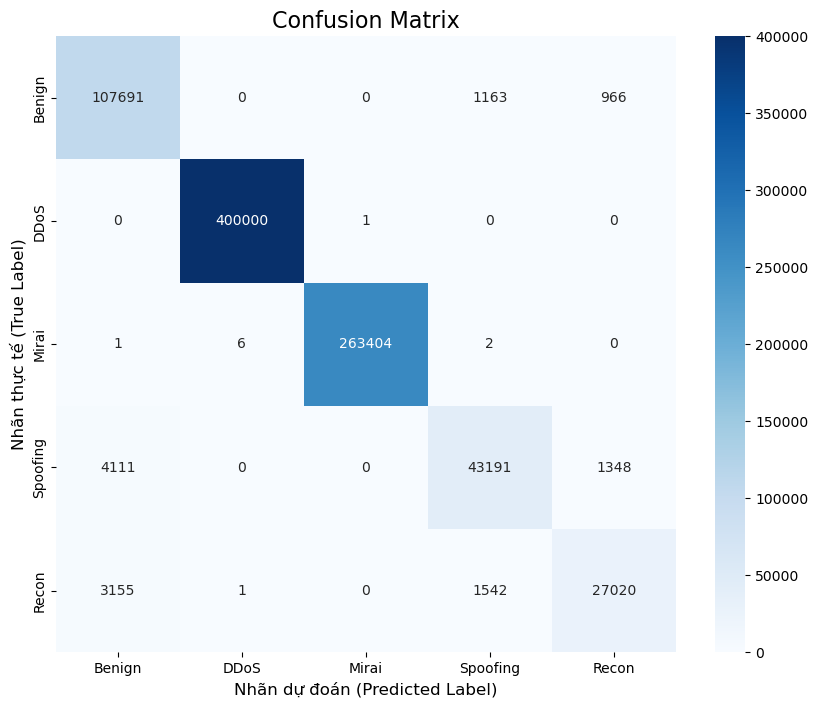


📊 Đang vẽ và lưu biểu đồ mức độ quan trọng của Features...
Đã lưu biểu đồ features quan trọng vào file: feature_importance.png


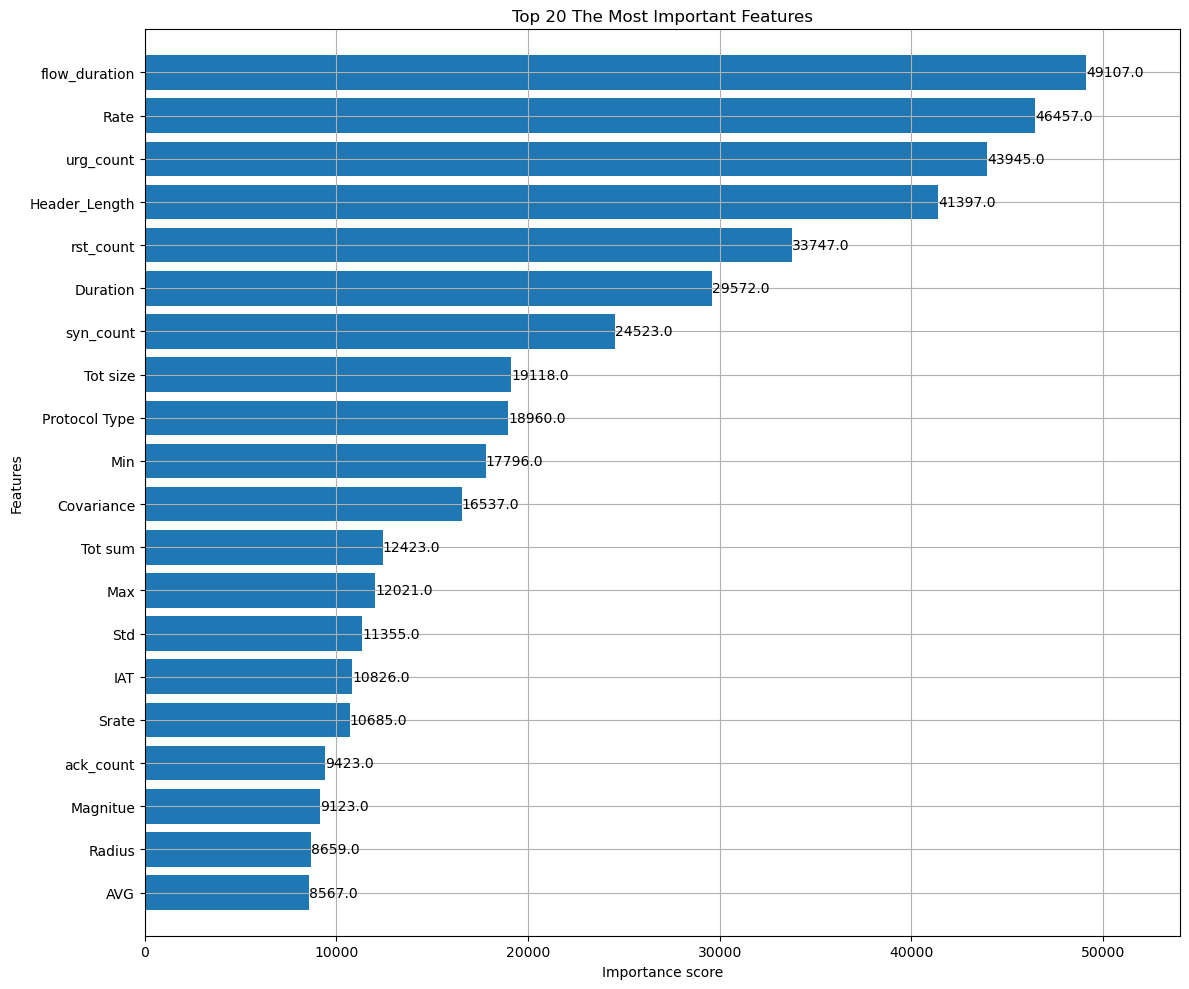


✅ Hoàn tất quá trình huấn luyện và đánh giá.


In [5]:
# 1. In các metrics chính
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', filename='confusion_matrix.png'):
    """
    Hàm này in, vẽ, và lưu ma trận nhầm lẫn.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=16)
    plt.ylabel('Nhãn thực tế (True Label)', fontsize=12)
    plt.xlabel('Nhãn dự đoán (Predicted Label)', fontsize=12)
    
    # Lưu biểu đồ thành file ảnh trước khi hiển thị
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Đã lưu ma trận nhầm lẫn vào file: {filename}")
    
    plt.show()
accuracy = accuracy_score(y_test, y_pred_test)
print(f"\n🎯 Độ chính xác (Accuracy) trên tập Test: {accuracy:.4f}")

print("\n📊 Báo cáo phân loại chi tiết (Classification Report):")
# Sử dụng CLASS_NAMES để hiển thị tên nhãn
print(classification_report(y_test, y_pred_test, target_names=CLASS_NAMES))

print("\n📈 Đang vẽ và lưu ma trận nhầm lẫn...")
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm, classes=CLASS_NAMES, title='Confusion Matrix', filename='confusion_matrix.png')

# 3. Vẽ và lưu biểu đồ mức độ quan trọng của features
print("\n📊 Đang vẽ và lưu biểu đồ mức độ quan trọng của Features...")
fig, ax = plt.subplots(figsize=(12, 10)) # Tạo figure và axes để có thể lưu lại
xgb.plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.8, title="Top 20 The Most Important Features")
plt.tight_layout()

# <<< THÊM VÀO ĐÂY >>>
# Lưu biểu đồ feature importance thành file ảnh
feature_importance_filename = 'feature_importance.png'
plt.savefig(feature_importance_filename, dpi=300, bbox_inches='tight')
print(f"Đã lưu biểu đồ features quan trọng vào file: {feature_importance_filename}")

plt.show()

print("\n✅ Hoàn tất quá trình huấn luyện và đánh giá.")

